## Exploration of the CTF Corruption (No CTF Correction)

In [1]:
import sys
import mrcfile
import torch
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('pscratch/sd/h/hnjones/tomo_suli/')
from fsc_mod import make_rfreq_radius_new

In [2]:
tilt_series = mrcfile.read('/global/cfs/projectdirs/xray/kpande/et_denoising/ribosome/noise_free/tiltseries_nonoise.mrc')

/global/homes/h/hnjones/.conda/envs/ddw_env/lib/python3.10/site-packages/mrcfile/mrcinterpreter.py:216: RuntimeWarning: Unrecognised machine stamp: 0x44 0x11 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


In [3]:
tilt_series = torch.tensor(tilt_series)

In [4]:
#61 micrographs, [-60, -58, ..., 0, 2, ...60]
print(tilt_series.shape)

torch.Size([61, 2000, 2000])


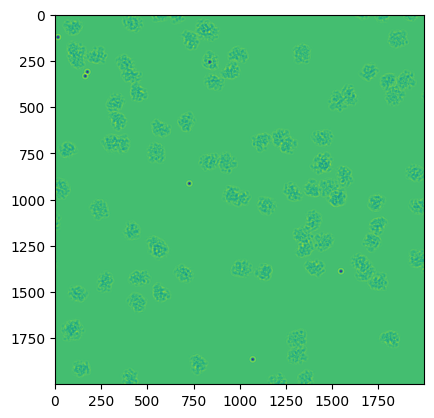

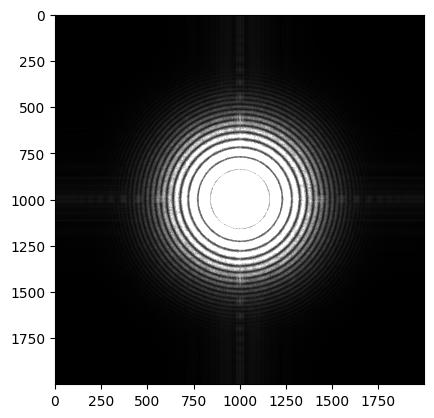

In [5]:
center_micrograph = tilt_series[30]
plt.imshow(center_micrograph.numpy())
plt.show()
plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fftn(center_micrograph))).numpy(), cmap= "gray", vmax = 50000)
plt.show()

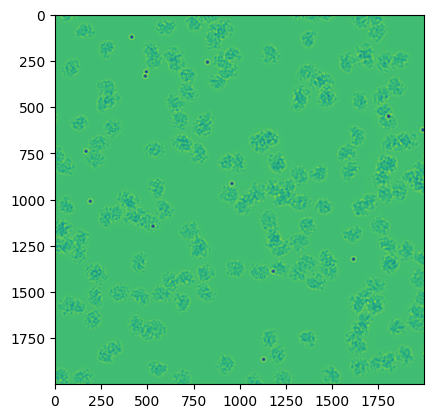

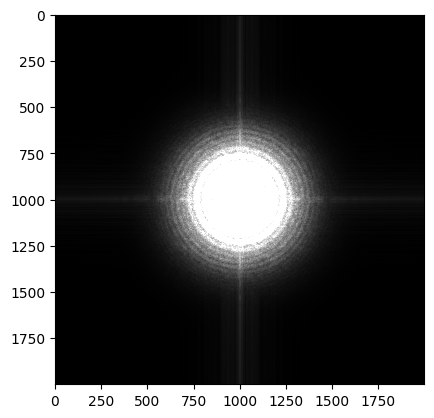

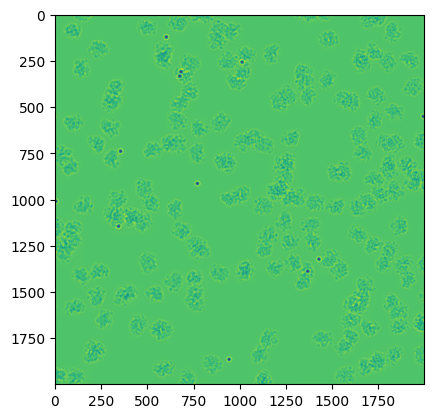

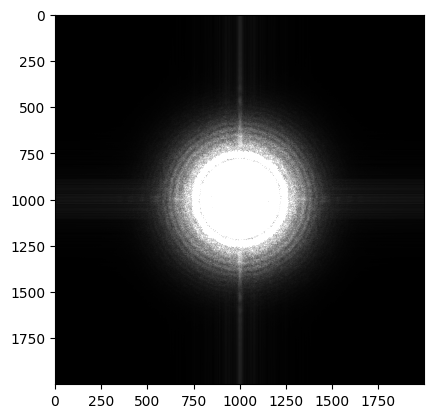

In [6]:
## extreme angle micrographs
early_micrograph = tilt_series[0]
plt.imshow(early_micrograph.numpy())
plt.show()
plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fftn(early_micrograph))).numpy(), cmap= "gray", vmax = 50000)
plt.show()

## extreme angle micrographs
late_micrograph = tilt_series[-1]
plt.imshow(late_micrograph.numpy())
plt.show()
plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fftn(late_micrograph))).numpy(), cmap= "gray", vmax = 50000)
plt.show()

### Zooming in on subtomogram

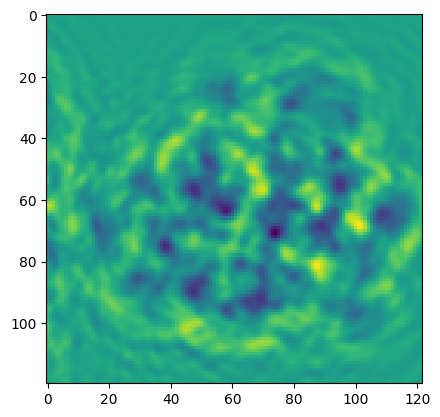

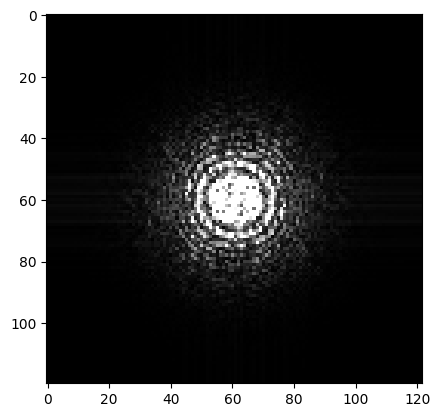

In [23]:
center_micrograph = tilt_series[30]
plt.imshow(center_micrograph.numpy()[160:280, 160: 160+122])
plt.show()
plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fftn(center_micrograph[160:280, 160:160+122]))).numpy(), cmap= "gray", vmax = 20000)
plt.show()

In [8]:
shape = torch.clone(torch.as_tensor(center_micrograph.shape))
freq_radius = make_rfreq_radius_new(shape)
sorted_frequencies_flat, sort_idx_flat = torch.sort(torch.flatten(freq_radius), descending = False)
del(freq_radius)
#spacing allows our spherical shell to encompass all data instead of the largest centered sphere, 
#ie a spherical slice out of a thin rectanular prism
bin_centers = torch.fft.rfftfreq(int(torch.min(torch.as_tensor(center_micrograph.shape))))
tensor1 = torch.fft.rfftn(center_micrograph)
bin_interval = bin_centers[1]
bin_centers = torch.cat([bin_centers, torch.arange(start = bin_centers[-1] + bin_interval,
                                                   end = np.sqrt(len(center_micrograph.shape) * 0.25) + bin_interval,
                                                    step = bin_interval )])
bin_centers = bin_centers.unfold(dimension=0, size=2, step=1)
bin_centers = torch.mean(bin_centers, dim = 1)
split_idx   = torch.searchsorted(sorted_frequencies_flat, bin_centers)
shell_index = torch.tensor_split(sort_idx_flat, split_idx)[:-1] #exlude last one because of binning
del(sorted_frequencies_flat, sort_idx_flat)
tensor1 = torch.flatten(tensor1)
avg_abs = ([torch.abs(torch.mean(tensor1[idx])) for idx in shell_index])

(-5.0, 15.0)

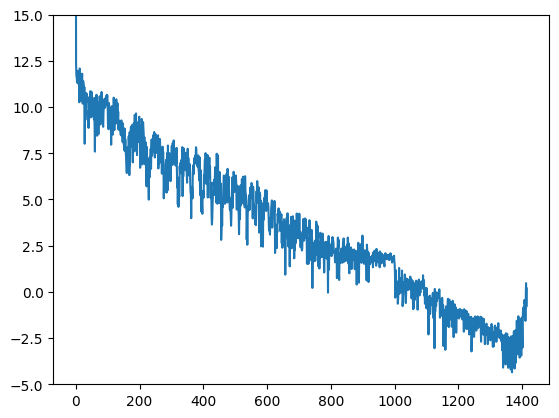

In [9]:
plt.plot(np.log(avg_abs))
plt.ylim(-5,15)